# Astronomy 499 Research: Winter & Spring 2022

In [1]:
import numpy as np
import scipy.constants as const
import matplotlib
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.units import cds
cds.enable()
import pandas as pd

In [2]:
# Equations from Stone 1996

latitude = -30.24463 * u.deg
longitude = -70.74942 * u.deg
altitude = 2647 * u.m
p0 = 101325 * u.Pa # sea level air presssure
g = const.g * (u.m/u.s**2)
R0 = 8.31447 * u.J/(u.mol*u.K) # gas constant
T0 = 19. * u.deg_C # typical sea level temperature
lapseRate = -6.5 * (u.deg_C/u.km) # typical rate of change of temperature with altitude
M = 0.0289644 * (u.kg/u.mol) # molar mass of dry air
humidity = 40. # typical humidity at many ovservatory sites

In [3]:
temperature = T0 + (lapseRate * altitude)
temperatureK = temperature.to(u.K, equivalencies = u.temperature())

pressure = (p0 * np.exp((-g * M * altitude) / (R0 * temperatureK))).to(u.Pa)

In [4]:
# calculating the water-vapor pressure (mm)
def power_vapor_pressure(temp, RH):
    t = temp.value
    x = np.log(RH/100)
    tdC_numerator = (((t + 238.3)*x) + (17.2694 * t))
    tdC_demoninator = ((t + 238.3) * (17.2694 - x)) - (17.2694 * t)
    tdC = (238.3 * (tdC_numerator/tdC_demoninator)) * u.deg_C
    t_dewpoint_C = tdC.value
    pressure = (4.50874 + (0.341724 * t_dewpoint_C) + (0.0106778 * t_dewpoint_C**2) + (0.184889e-3 * t_dewpoint_C**3) + (0.238294e-5 * t_dewpoint_C**4) + (0.203447e-7 * t_dewpoint_C**5)) * u.cds.mmHg
    return pressure

p_w = (power_vapor_pressure(temperature, humidity)).to(u.cds.mbar)
p_s = pressure.to(u.cds.mbar)
zin = 30 * u.deg

In [5]:
# Using Equations: 4, 5, 9, 10, 14, 15, 16, 18, 20, 21 + 2

def gammafunction(wavelength, Ps_in, Tinitial, Pw_in):
    T = Tinitial.to(u.K, equivalencies = u.temperature()).value
    sigma = 1/wavelength.to(u.um).value
    
    Ps = Ps_in.to(u.cds.mbar).value
    Pw = Pw_in.to(u.cds.mbar).value
    
    Ds = (1 + (Ps * (57.90e-8 - (9.3250e-4/T) + (0.25844/T**2)))) * (Ps/T)
    Dw = (1 + (Pw * (1 + 3.7e-4 * Pw) * (-2.37321e-3 + ((2.23366/T)-(710.792/T**2) + (7.75141e4/T**3))))) * (Pw/T)
    term_one = (2371.34 + (683939.7/(130 - sigma**2)) + (4547.3/(38.9 - sigma**2))) * Ds
    term_two = ((6487.31 + (58.058 * sigma**2) - (0.71150 * sigma**4) + (0.08851 * sigma**6))) * Dw
    n = ((term_one + term_two) / (1e8))
    return n

def calc_beta(tin):
    t = tin.value
    beta = 0.001254 * ((273.15 + t)/273.15)
    return beta

def calc_kappa(phi_degrees, height): # 10
    phi = phi_degrees.to(u.rad).value
    h = height.value
    kappa = 1 + (0.005302 * (np.sin(phi)**2)) - (0.00000583 * (np.sin(2 * phi)**2)) - (0.000000315 * h)
    return kappa
    
# Atmospheric refraction
def atm_refraction(wavelength, Ps, Tinitial, Pw, phi, h, z0):
    gamma = gammafunction(wavelength, Ps, Tinitial, Pw)
    beta = calc_beta(Tinitial)
    kappa = calc_kappa(phi , h)
    
    refraction = (kappa * gamma * (1 - beta) * np.tan(z0.to(u.rad))) - (kappa * gamma * (beta - (gamma / 2)) * (np.tan(z0.to(u.rad))**3))
    
    return refraction
    
    

In [6]:
# Conversions
rad2arcsec = (206265 * u.arcsec) # radians to arcseconds

In [14]:
# Import Data

# g-band
gband = pd.read_csv('total_g.dat', delimiter = " ", comment = "#", header=None, skipinitialspace = True)
gband_wavelength = np.array(gband[0]) * u.nm
gband_throughput = np.array(gband[1])

# i-band
iband = pd.read_csv('total_i.dat', delimiter = " ", comment = "#", header=None, skipinitialspace = True)
iband_wavelength = np.array(iband[0]) * u.nm
iband_throughput = np.array(iband[1])

# General
column_names = ['Wave', 'FluxD', 'e_FluxD']
simulatedquasarspectrum = pd.read_csv('Vanden_Berk_quasars.txt', delimiter = " ", header=None, skipinitialspace = True, names = column_names, skiprows=23)
subsection = simulatedquasarspectrum
subsection = simulatedquasarspectrum.apply(pd.to_numeric, errors='coerce')

data = subsection[['Wave', 'FluxD', 'e_FluxD']]

# Wavelength from Data
wavelength_or = np.array(subsection['Wave']) * u.Angstrom
wavelength_nm = (wavelength_or[23:]).to(u.nm)

In [19]:
# Defining Variables

#General Wavelength Linspace
wavelength_values = np.linspace(300, 1000, 100) * u.nm

# Relative Flux Density
relative_fluxdensity = subsection['FluxD'][23:]

#Incident Angle
zin = 30 * u.deg

#Total Refraction
refraction = atm_refraction(wavelength_values, p_s, temperature, p_w, latitude, altitude, zin)

# Assignment 1: 
## Part 1a - Total Refraction vs. Wavelength

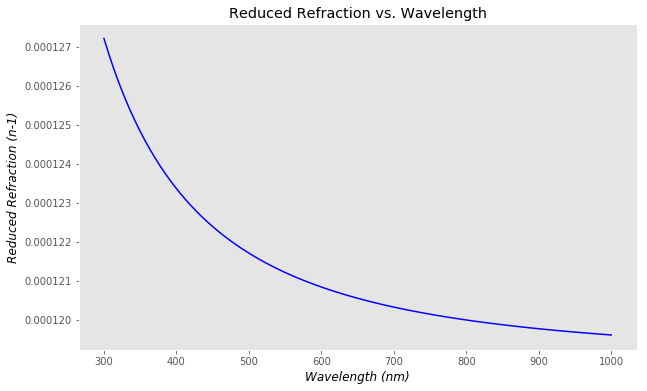

In [20]:
# Plot: Total Refraction vs. Wavelength
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.plot(wavelength_values, refraction, color = 'b')
ax.set_title('Reduced Refraction vs. Wavelength', color = 'k')
ax.set_xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k')
ax.set_ylabel('Reduced Refraction (n-1)', fontstyle = 'italic', color = 'k');
ax.grid()

## Part 1b: Plot Simulated Quasar Spectra

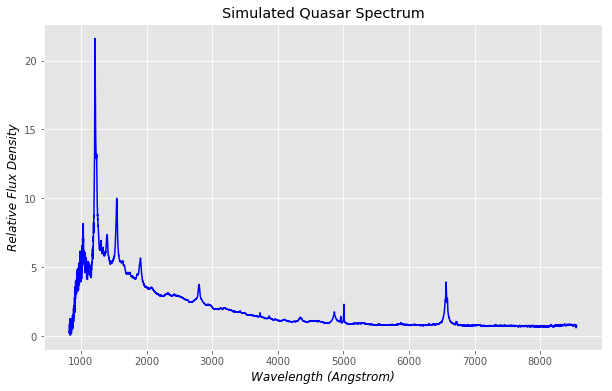

In [26]:
# Plot of Simulated Quasar Spectrum
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.plot(wavelength_or[23:], relative_fluxdensity, color = 'b')
plt.title('Simulated Quasar Spectrum', color = 'k')
plt.xlabel('Wavelength (Angstrom)', fontstyle = 'italic', color = 'k')
plt.ylabel('Relative Flux Density', fontstyle = 'italic', color = 'k');

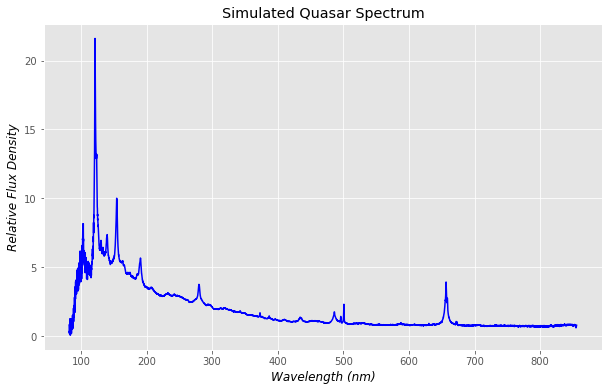

In [24]:
# Plot of Simulated Quasar Spectrum
fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.plot(wavelength_nm, relative_fluxdensity, color = 'b')
plt.title('Simulated Quasar Spectrum', color = 'k')
plt.xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k')
plt.ylabel('Relative Flux Density', fontstyle = 'italic', color = 'k');

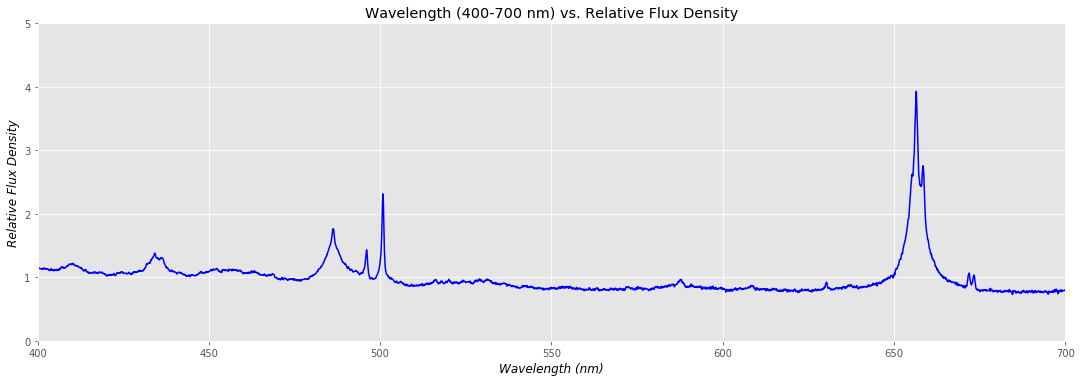

In [27]:
# Plot between 400-700 nm
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15, 5)
fig.tight_layout()

# Set x-limit 400<x<700
ax.set_xlim(400,700)
ax.set_ylim(0, 5)

# Plot spectrum
ax.plot(wavelength_nm, relative_fluxdensity, color = 'b')

# Set labels
ax.set_xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k')
ax.set_ylabel('Relative Flux Density', fontstyle = 'italic', color = 'k')
ax.set_title('Wavelength (400-700 nm) vs. Relative Flux Density', color = 'k');

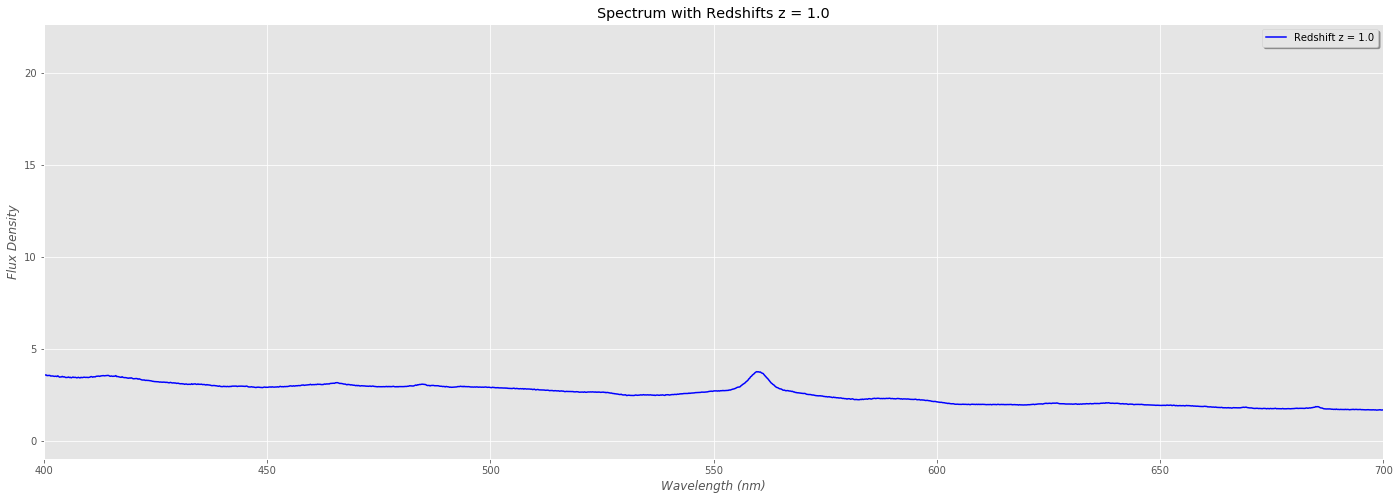

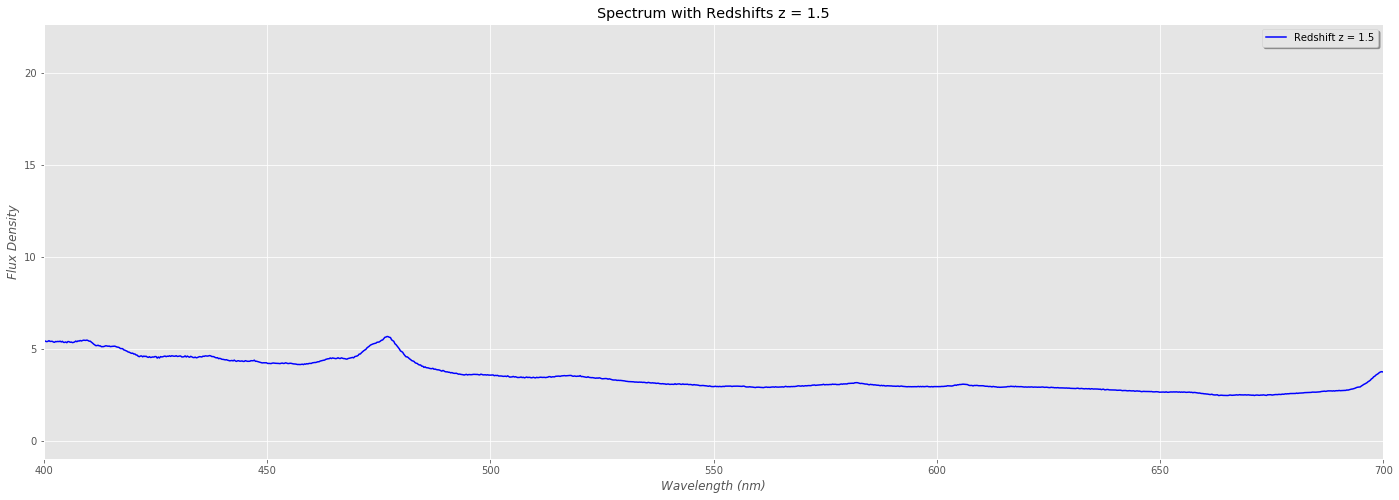

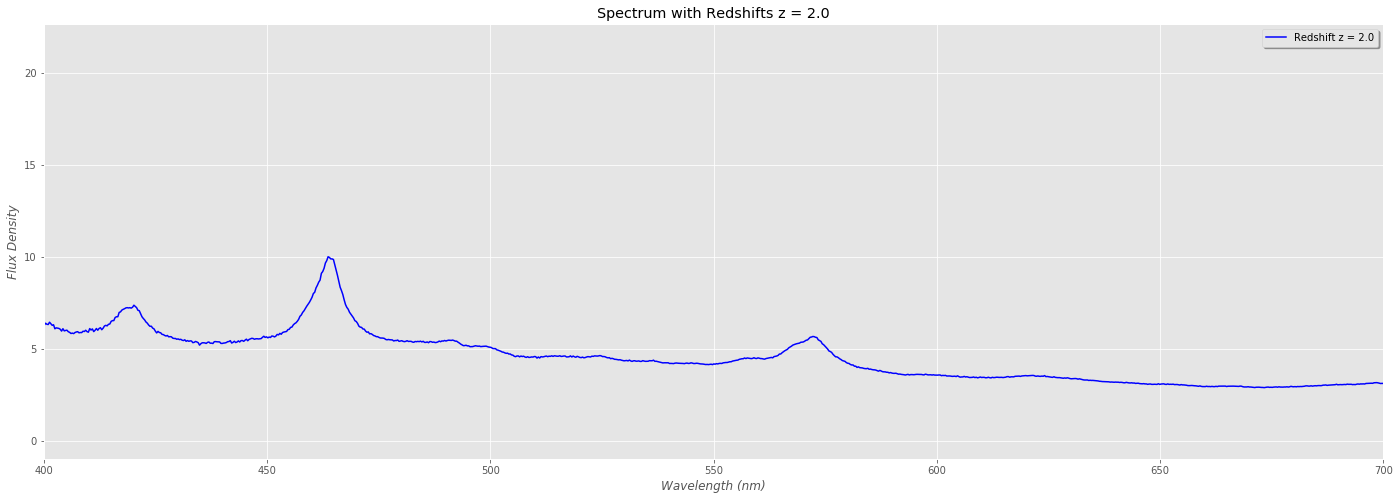

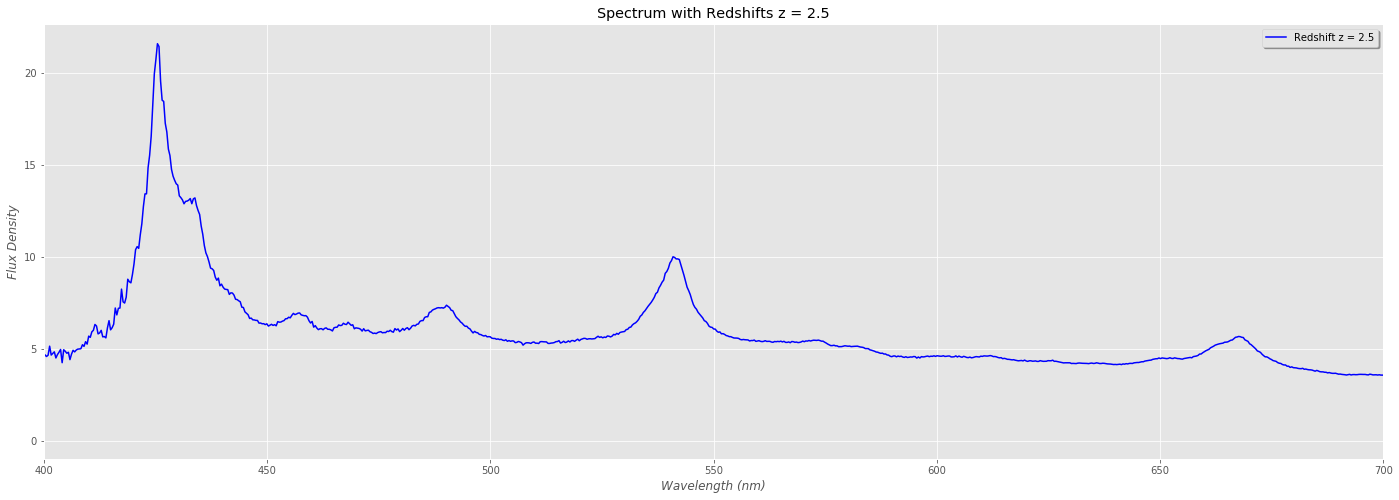

In [29]:
# Defining Redshift Function
def redshift(z, spectrum_wavelength):
    redshiftspectrum = (1 + z) * spectrum_wavelength
    return redshiftspectrum

# Redshift Spectra
spectra = [redshift(1.0, wavelength_nm), redshift(1.5, wavelength_nm), redshift(2.0, wavelength_nm), redshift(2.5, wavelength_nm)]

# Spectrum between 400-700 nm
redshifts = [1.0, 1.5, 2.0, 2.5]
for s, z in zip(spectra, redshifts):
    fig, ax = plt.subplots (figsize = (24,8))
    plt.plot(s, relative_fluxdensity, label = 'Redshift z = {}'.format(z), color = 'b')
    plt.xlabel('Wavelength (nm)', fontstyle = 'italic')
    plt.ylabel('Flux Density', fontstyle = 'italic')
    plt.title('Spectrum with Redshifts z = {}'.format(z))
    plt.xlim(400,700)
    plt.legend(loc = 0, shadow = True);


## Part 1c: Throughput Plots

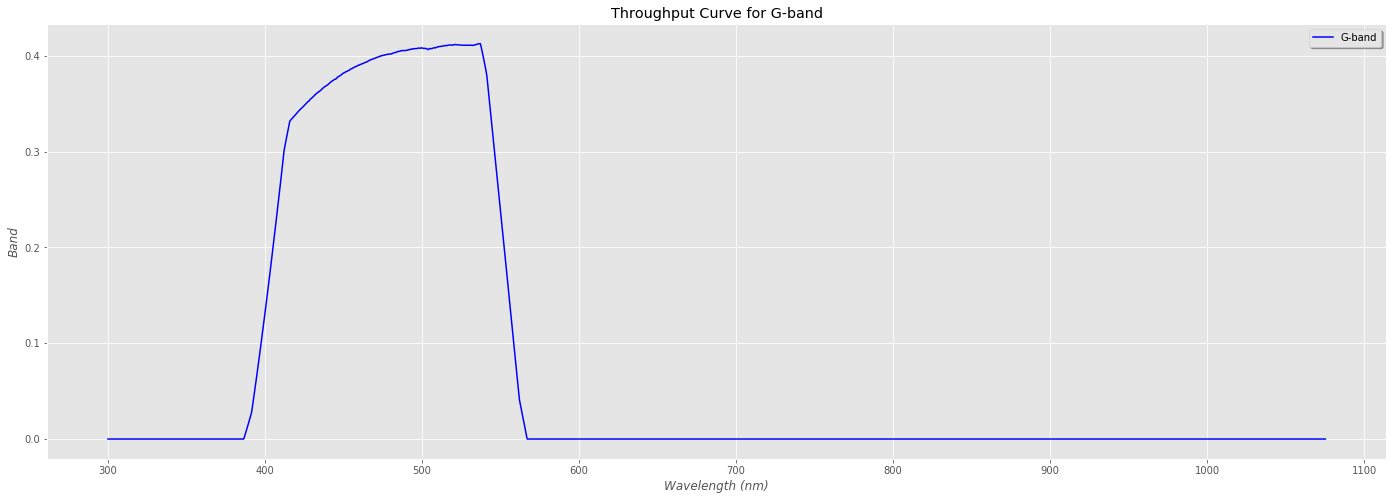

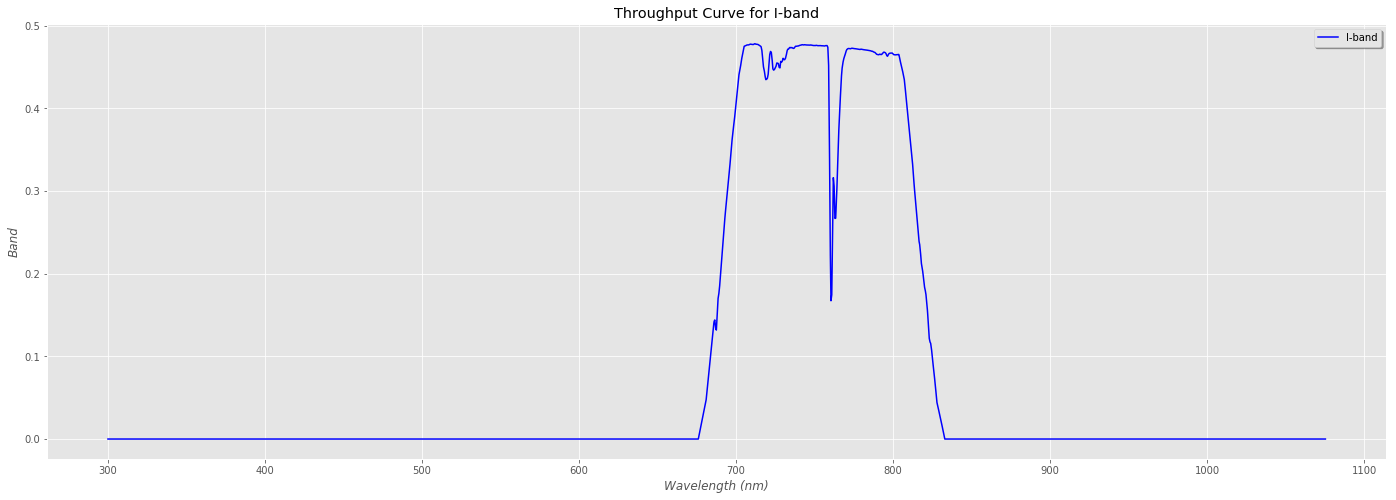

In [30]:
# Plot Total Bandpasses

bands = ['G-band', 'I-band']
wavelengths = [gband_wavelength[0:7755], iband_wavelength[0:7755]]
bandpasses = [gband_throughput[0:7755], iband_throughput[0:7755]]

for b, w, f in zip(bands, wavelengths, bandpasses):
    fig, ax = plt.subplots (1, 1, figsize = (24,8))
    plt.plot(w, f, label = '{}'.format(b), color = 'b')
    plt.xlabel('Wavelength (nm)', fontstyle = 'italic')
    plt.ylabel('Band', fontstyle = 'italic')
    plt.title('Throughput Curve for {}'.format(b))
    plt.legend(loc = 0, shadow = True);

val = np.where(gband_throughput==0)
temp = np.delete(gband_throughput,val)

## Part 2a: Observed Bandpasses

In [ ]:
#Defining Condensed Observed Spectra Variable
spectra_obs = [wavelength_nm, redshift(1.0, wavelength_nm), redshift(1.5, wavelength_nm), redshift(2.0, wavelength_nm), redshift(2.5, wavelength_nm)]


In [39]:
def observedBandpass(wavelength, throughput, redshifts, spectra, bandName):
    for z, s in zip(redshifts, spectra_obs):
        fig, ax = plt.subplots (1, 1, figsize = (24,8))
        interpolate = np.interp(s, gband_wavelength[0:7755], gband_throughput[0:7755])
        plt.plot(s, relative_fluxdensity * interpolate, label = 'Redshift z = {}'.format(z), color = 'b')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Flux')
        plt.title('{}: Wavelength vs. Flux for z = {}'.format(bandName,z))
        plt.xlim(350, 600)
        plt.legend(loc = 0, shadow = True);

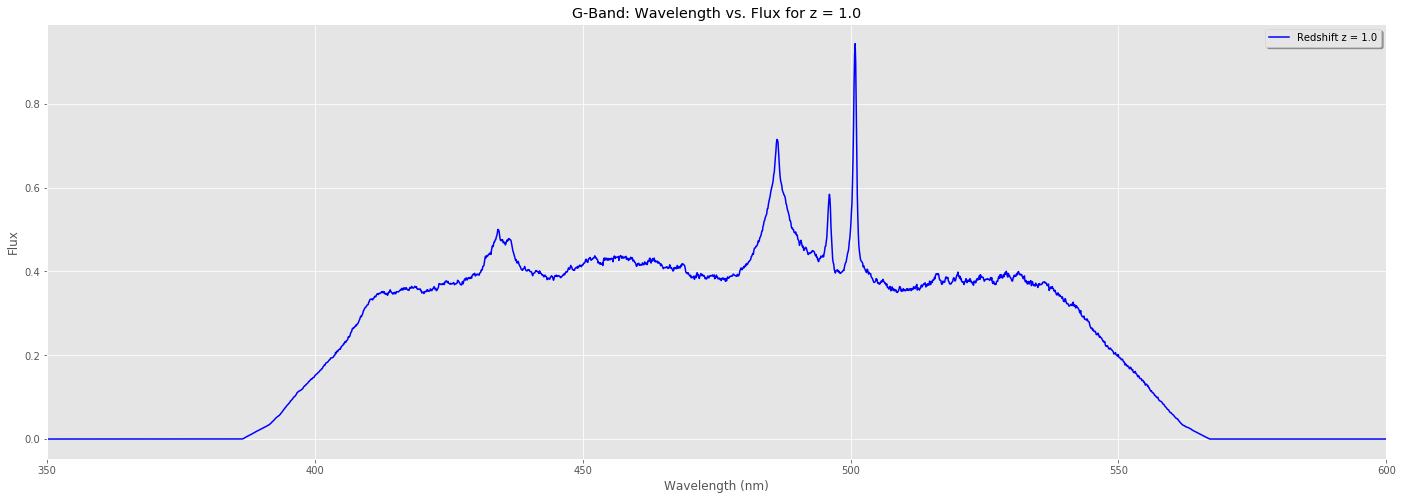

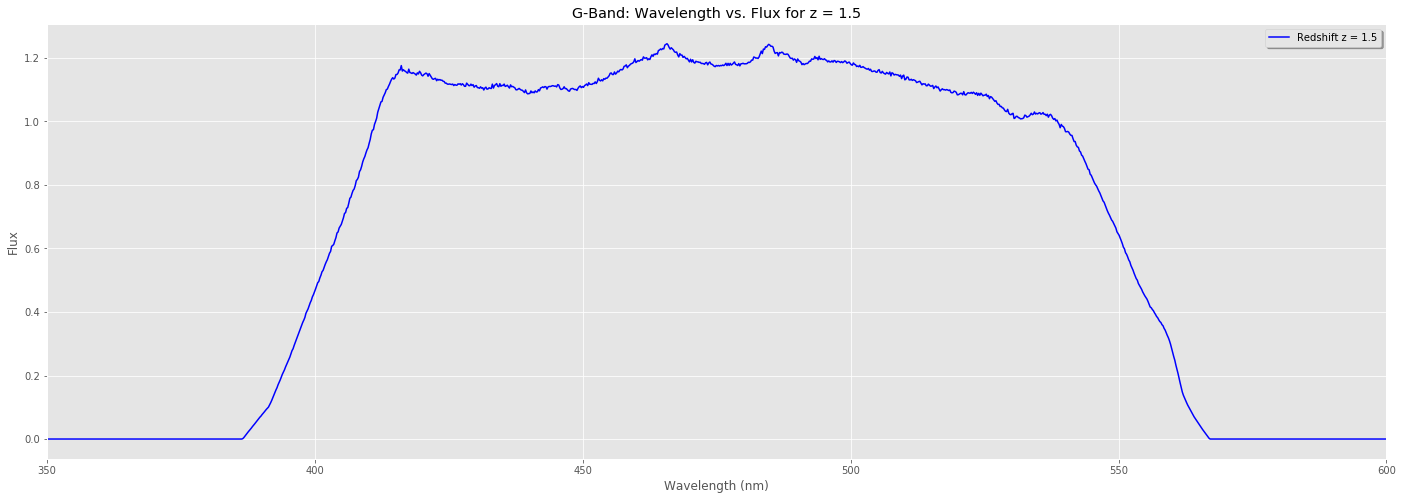

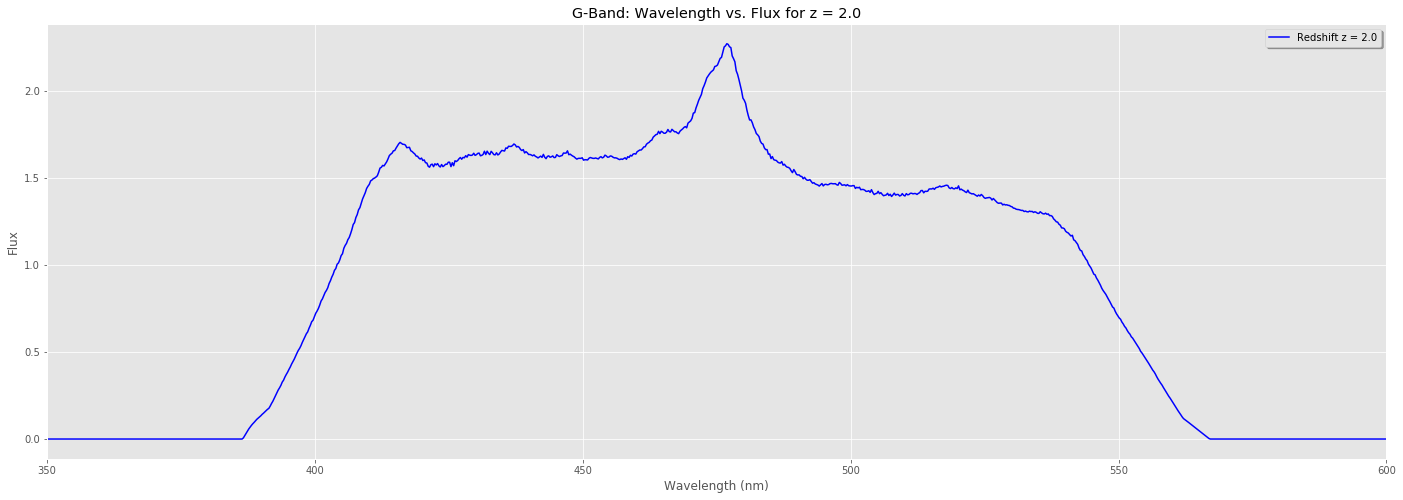

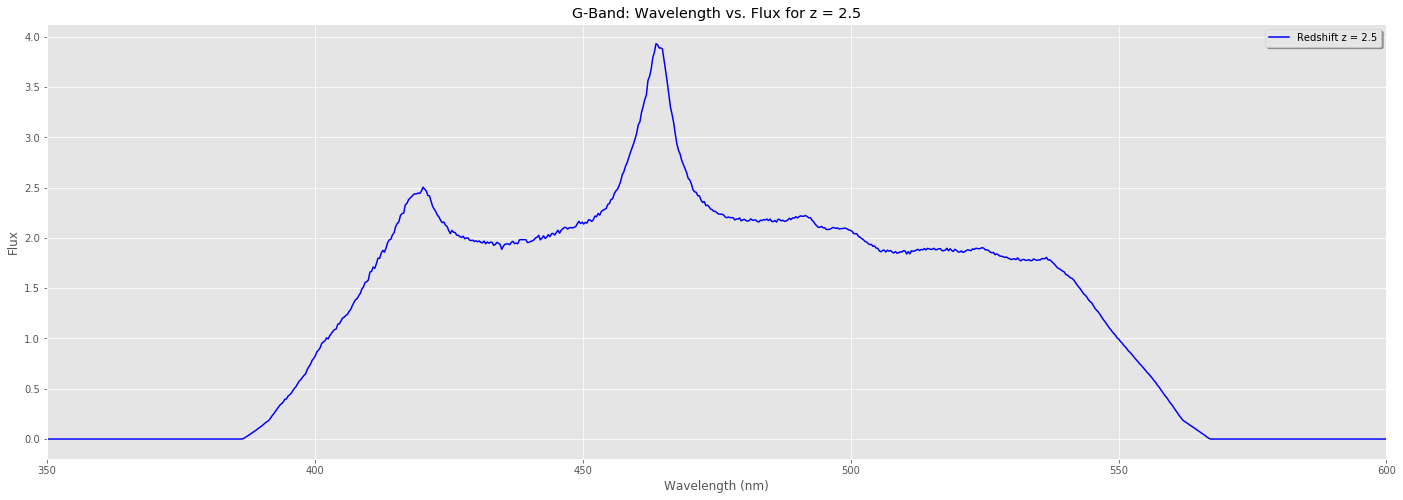

In [41]:
# G-Band Observed Bandpasses
gband_observedBandpasses = observedBandpass(gband_wavelength[0:7755], gband_throughput[0:7755], redshifts, spectra_obs, 'G-Band')



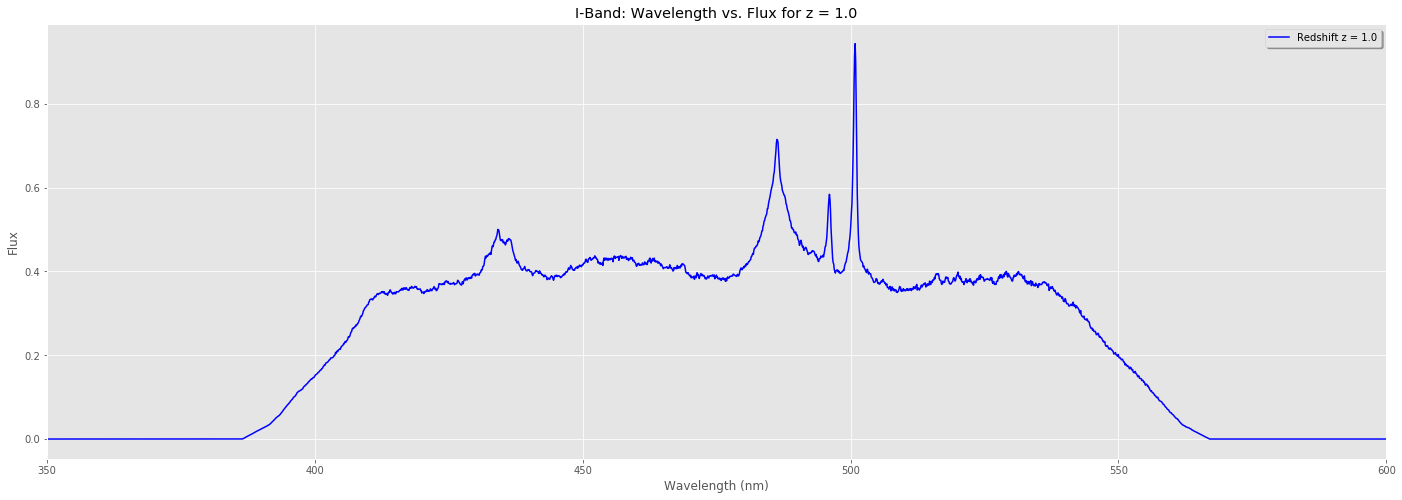

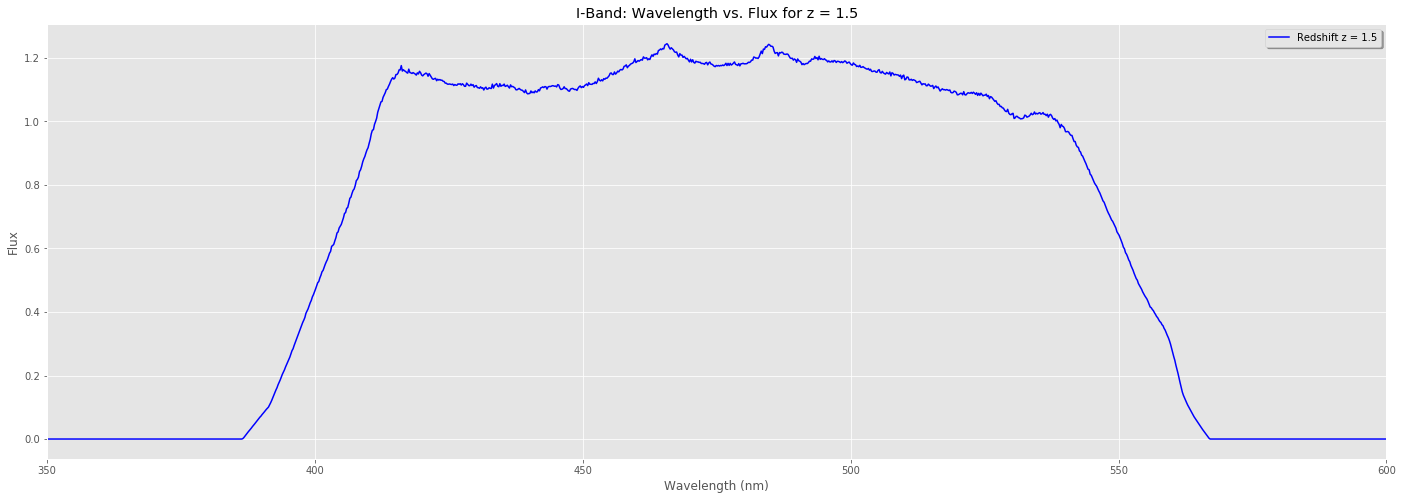

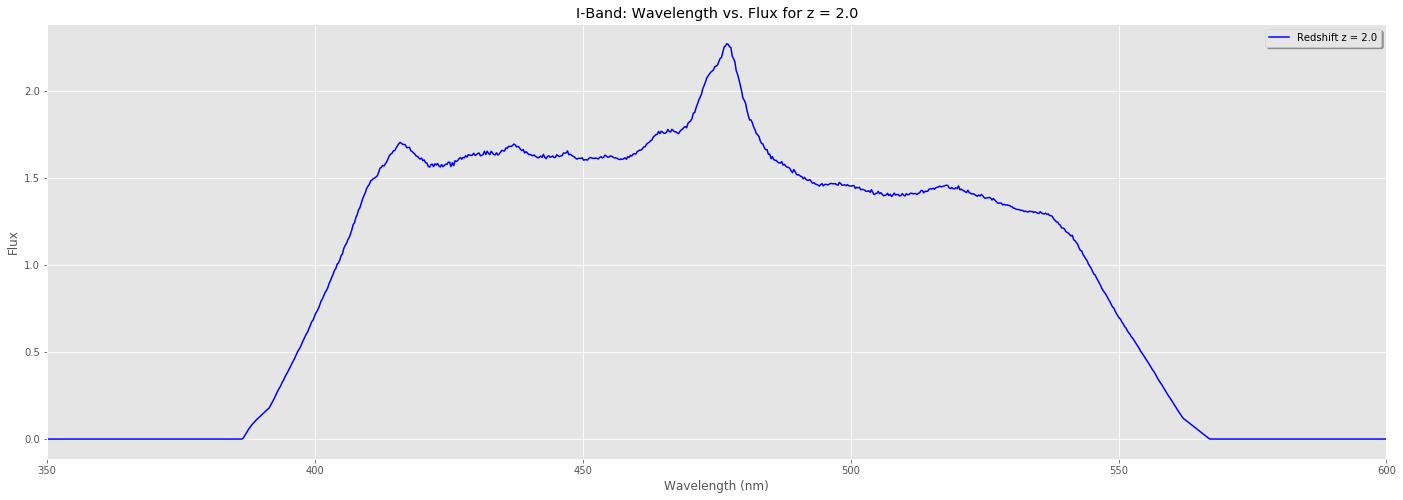

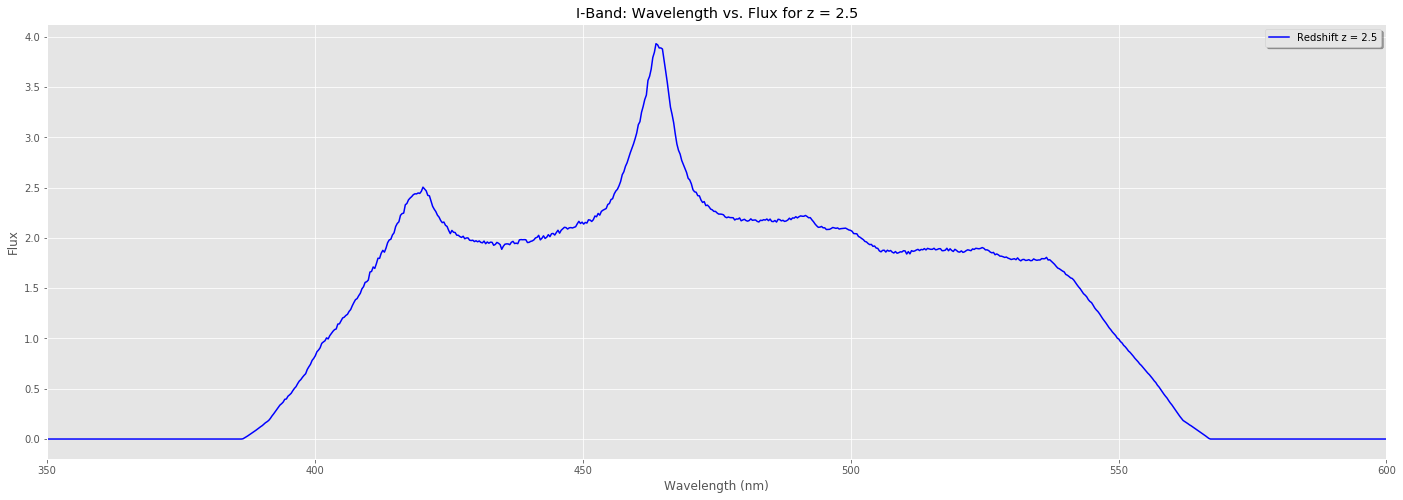

In [42]:
# I-Band Observed Bandpasses
iband_observedBandpasses = observedBandpass(iband_wavelength[0:7755], iband_throughput[0:7755], redshifts, spectra_obs, 'I-Band')



## Part 2b: Defining Subbands

In [82]:
# Defining Subbands
def subbands(wavelength, throughput, number_bands):
    sum_ts = np.sum(throughput)
    cum_ts = np.cumsum(throughput)
    
    bounds = []
    for b in range(number_bands - 1):
        bound = ((1 + b) / number_bands) * sum_ts
        wlgth = np.interp(bound, cum_ts, wavelength)
        bounds.append(wlgth)
        
    return bounds

In [44]:
#Defining Wavlength Bounds for Subbands
def subband_wavelengths(band_wavelength, band_throughput, subband_number, minwavelength = 100, maxwavelength = 10000):
    bounds = subbands(band_wavelength, band_throughput, subband_number)
    
    effective_wavelengths = []
    
    for b in range(subband_number):
        if b == 0:
            lowerbound = minwavelength
        else:
            lowerbound = bounds[b-1]
            
        if b == subband_number-1:
            upperbound = maxwavelength
            
        else:
            upperbound = bounds[b]
        
        subband = (band_wavelength.value > lowerbound) & (band_wavelength.value < upperbound) 
        
        effective_wavelength = np.average(band_wavelength[subband], weights = band_throughput[subband])
        effective_wavelengths.append(effective_wavelength)
        
    return effective_wavelengths
    
    

In [94]:
#G-Band Subbands
g_subbands = subband_wavelengths(gband_wavelength[0:7755], gband_throughput[0:7755], 3)
g_subbands


[<Quantity 429.82696496 nm>,
 <Quantity 480.9518105 nm>,
 <Quantity 529.08487633 nm>]

In [95]:
#I-Band Subbands
isubbands = subband_wavelengths(iband_wavelength[0:7755], iband_throughput[0:7755], 3)
isubbands


[<Quantity 711.06122426 nm>,
 <Quantity 753.89535794 nm>,
 <Quantity 797.67544 nm>]

## Part 3a: Effective Wavelegnth

In [58]:
# Calculate the effective wavelength

def weightedWavelength(wavelength, throughput, bandName):
    ww = np.average(wavelength, weights = throughput)
    print("The effective wavelength of the LSST {} is {:.2f}.".format(bandName, ww))
    return ww

gWeightedWavelength = weightedWavelength(gband_wavelength[0:7755], gband_throughput[0:7755], 'G-Band')
iWeightedWavelength = weightedWavelength(iband_wavelength[0:7755], iband_throughput[0:7755], 'I-Band')


The effective wavelength of the LSST G-Band is 480.00 nm.
The effective wavelength of the LSST I-Band is 754.22 nm.


## Part 3b: Differential Refraction

In [60]:
def differentialRefraction(weightedWavelength, p_s, temperature, p_w, latitude, altitude, zin, bandName):
    refractionindex_effective = atm_refraction(weightedWavelength, p_s, temperature, p_w, latitude, altitude, zin)
    difference = (refraction * rad2arcsec) - (refractionindex_effective * rad2arcsec)
    
    fig, ax = plt.subplots(1, 1, figsize = (24, 10))
    plt.plot(wavelength_values, difference, label = bandName, color = 'b')
    ax.set_title('Refraction Difference (arcseconds) vs. Wavelength (nm)', color = 'k', fontsize = 16)
    ax.set_xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k', fontsize = 16)
    ax.set_ylabel('Refraction Difference (arcseconds)', fontstyle = 'italic', color = 'k', fontsize = 16);

    ax.legend(loc = 0, shadow = True);
    
    

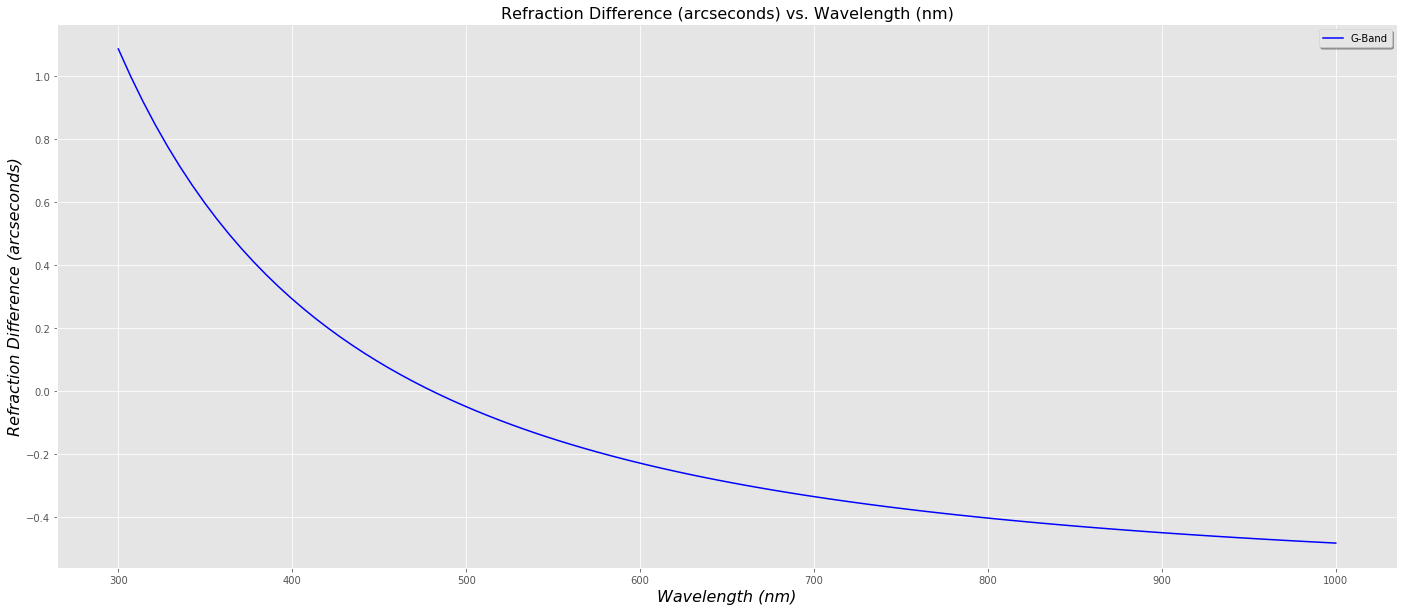

In [61]:
#G-Band Differential Refraction
g_df = differentialRefraction(gWeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin, 'G-Band')



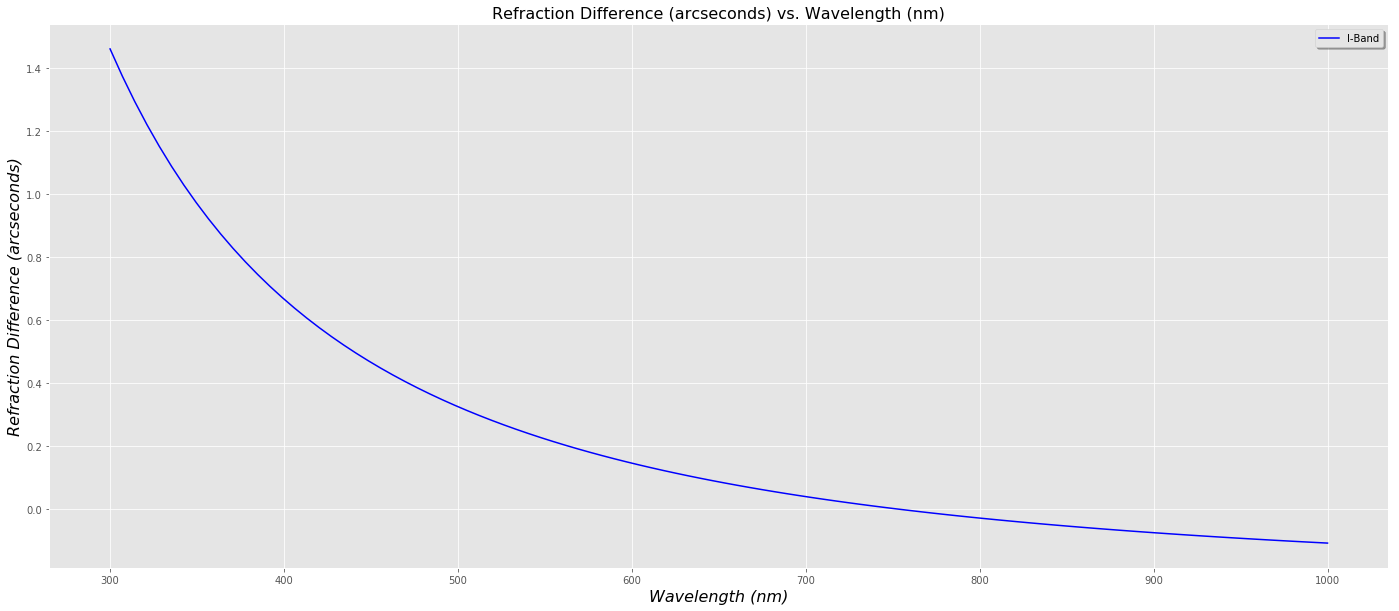

In [62]:
#I-Band Differential Refraction

i_df = differentialRefraction(iWeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin, 'I-Band')

# Assignment 2

## Part 1a: Basic Point Spread Function (PSF) Modeling

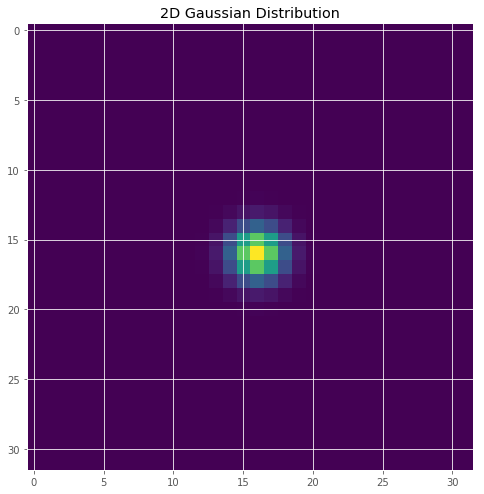

In [63]:
# Convert from fwhm to sigma
fwhm_conversion = 2 * np.sqrt(2 * np.log(2))

# Creating 2D Gaussian Functions
def gaussian2d(x_dimension = 32, y_dimension = 32, xcenter = 16, ycenter = 16, sigmax = (0.8/0.26)/fwhm_conversion, sigmay = (0.8/0.26)/fwhm_conversion):
    x = np.linspace(0, x_dimension-1, x_dimension)
    y = np.linspace(0, y_dimension-1, y_dimension)
    x, y = np.meshgrid(x, y)
    
    diffx = x - xcenter
    diffy = y - ycenter
    gaussian = np.exp(-((diffx**2/(2*sigmax**2))+(diffy**2/(2*sigmay**2))))
    
    return gaussian

# Defining X, Y & Gaussian Values
gaussian_2d = gaussian2d()

# Plot of Gaussian Distribution
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize = (8, 24))
ax.imshow(gaussian_2d)
ax.set_title('2D Gaussian Distribution');

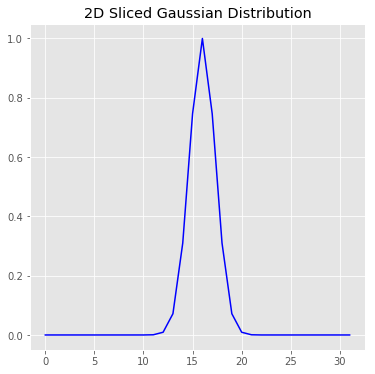

In [64]:
# Verify with 1D Plot (slice of numpy array at x = 16)
sliced_gaussian = gaussian_2d[:,16] #y, x

# Plot
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.plot(sliced_gaussian, color = 'b')
ax.set_title('2D Sliced Gaussian Distribution');

## Part 1b: Offset Gaussian

In [65]:
def offset_2dgaussian(fwhm, flux, xoffset, yoffset):
    
    sigma = fwhm / 0.26/fwhm_conversion
    gaussian = gaussian2d(x_dimension=32, y_dimension=32, xcenter=16, ycenter=16+yoffset, sigmax=sigma, sigmay=sigma)
    gaussian /= np.sum(gaussian)
    
    return gaussian*flux 

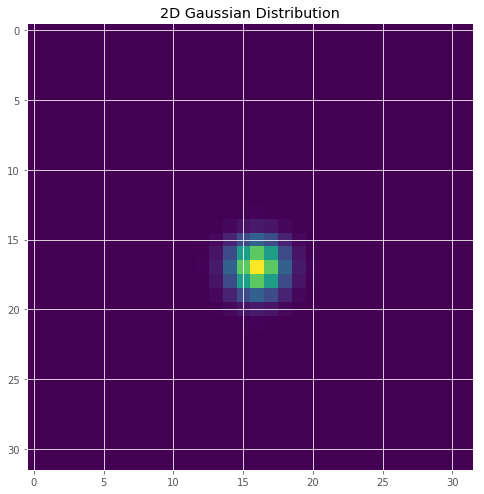

In [67]:
# Plot of Gaussian Distribution
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize = (8, 24))
temp = offset_2dgaussian(.8, 2.3456, 0,1)
ax.imshow(temp)
ax.set_title('2D Gaussian Distribution');

## Part 2a: Observed Quasar Model

In [68]:
def totalImage(band_wavelength, band_throughput, observed_spectra, relative_fluxdensity, WeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin, fwhm, xcenter, ycenter):
    image_comp = np.zeros((32, 32), ) # float by default
    refractionindex_eff = atm_refraction(WeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin)
    yoffset_value = []
    
    fmin = max(band_throughput)*.01
    w_use = []
    for w,f in zip(band_wavelength, band_throughput):
        if f < fmin:
            continue
        w_use.append(w.value)
        
        # calculate flux - 2a
        interpolate = np.interp(w, observed_spectra, relative_fluxdensity)
        flux = f * interpolate
        
        # dcr shift - 3b
        refraction = atm_refraction(w, p_s, temperature, p_w, latitude, altitude, zin)
        yoffset = (refraction - refractionindex_eff)* rad2arcsec.value / 0.26
        yoffset_value.append(yoffset)
        xoffset = 0 / 0.26 # shift purely in the y-direction
        
        # creating gaussian
        newgaussian = offset_2dgaussian(fwhm, flux, xoffset, yoffset)
        image_comp += newgaussian.value

    fig, ax = plt.subplots(1, 1, figsize = (6, 6))
    im = ax.imshow(image_comp)
    fig.colorbar(im, orientation = 'vertical')
    ax.set_title('2D Offset Gaussian Distribution');  
    
    return w_use, yoffset_value, image_comp

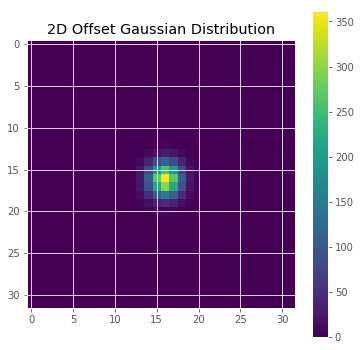

In [69]:
# G-Band Image
g_wls, gimage, gdistribution = totalImage(gband_wavelength, gband_throughput, spectra_obs[4], relative_fluxdensity, gWeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin, 0.8, 16, 16)



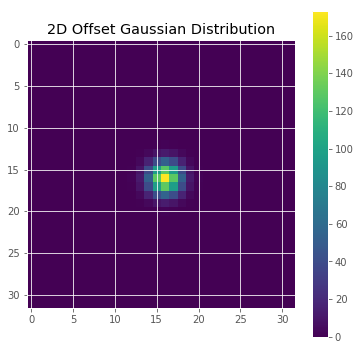

In [70]:
# I-Band Image
w_use, iimage, idistribution = totalImage(iband_wavelength, iband_throughput, spectra_obs[4], relative_fluxdensity, iWeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin, 0.8, 16, 16)


In [75]:
def slicedGaussian1D(distribution, image, bandName):
    sliced_total = distribution[:,16] #y, x
    type(image[0])

    # Plot
    fig, ax = plt.subplots(1, 1, figsize = (6, 6))
    ax.plot(sliced_total, color = 'b')
    ax.set_title('2D Sliced Gaussian Distribution {}'.format(bandName));

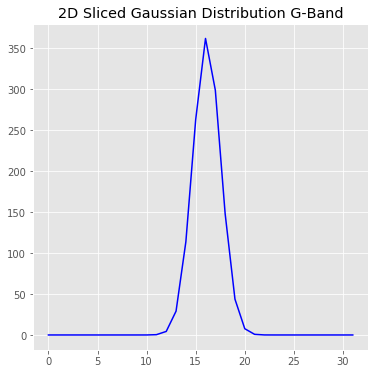

In [77]:
#1D G-Band Slice
slicedG = slicedGaussian1D(gdistribution, gimage, "G-Band")

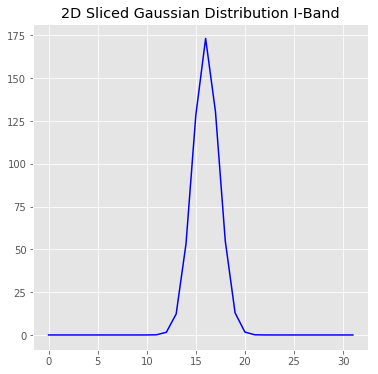

In [79]:
#1D I-Band Slice
slicedI = slicedGaussian1D(idistribution, iimage, "I-Band")

# Assignment 3

## Part 1a: Calculating Sub-Bands

## Part 1b: DCR Shifts

In [105]:
def DCRshift(subband_effWavelength, effectiveWavelength, p_s, temperature, p_w, latitude, altitude, zin):
    grefraction_subband = atm_refraction(subband_effWavelength, p_s, temperature, p_w, latitude, altitude, zin)
    grefraction_effective = atm_refraction(effectiveWavelength, p_s, temperature, p_w, latitude, altitude, zin)
    g_difference =  (grefraction_subband - grefraction_effective) * rad2arcsec /0.26 # in pixels
    
    return g_difference.value

def difference(band_wavelength, band_throughput, subband, subband_number=3):
    overall_effective_wavelength = subband_wavelengths(band_wavelength, band_throughput, subband_number=1)
    subband_effective_wavelengths = subband_wavelengths(band_wavelength, band_throughput, subband_number=3)
    wavelengths = [wl.value for wl in subband_effective_wavelengths]
    
    difference = DCRshift(subband_effective_wavelengths[subband], overall_effective_wavelength[0])
    return difference



In [109]:
def plot_subbands(band_wavelength, band_throughput, label_name, subband_number=3):
    
    overall_effective_wavelength = subband_wavelengths(band_wavelength, band_throughput, subband_number=1)
    subband_effective_wavelengths = subband_wavelengths(band_wavelength, band_throughput, subband_number=3)
    wavelengths = [wl.value for wl in subband_effective_wavelengths]
    
    differences = [DCRshift(subband,overall_effective_wavelength[0],p_s, temperature, p_w, latitude, altitude, zin) for subband in subband_effective_wavelengths]
    
    fig, ax = plt.subplots(1, 1, figsize = (24, 10))
    plt.plot(wavelengths, differences, label = label_name, color = 'b', marker='+') #label = 'g-band', color = 'b', marker='+')
    ax.set_title('Refraction Difference (pixels) vs. Wavelength (nm)', color = 'k', fontsize = 16)
    ax.set_xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k', fontsize = 16)
    ax.set_ylabel('Refraction Difference (pixels)', fontstyle = 'italic', color = 'k', fontsize = 16);

    ax.legend(loc = 0, shadow = True);

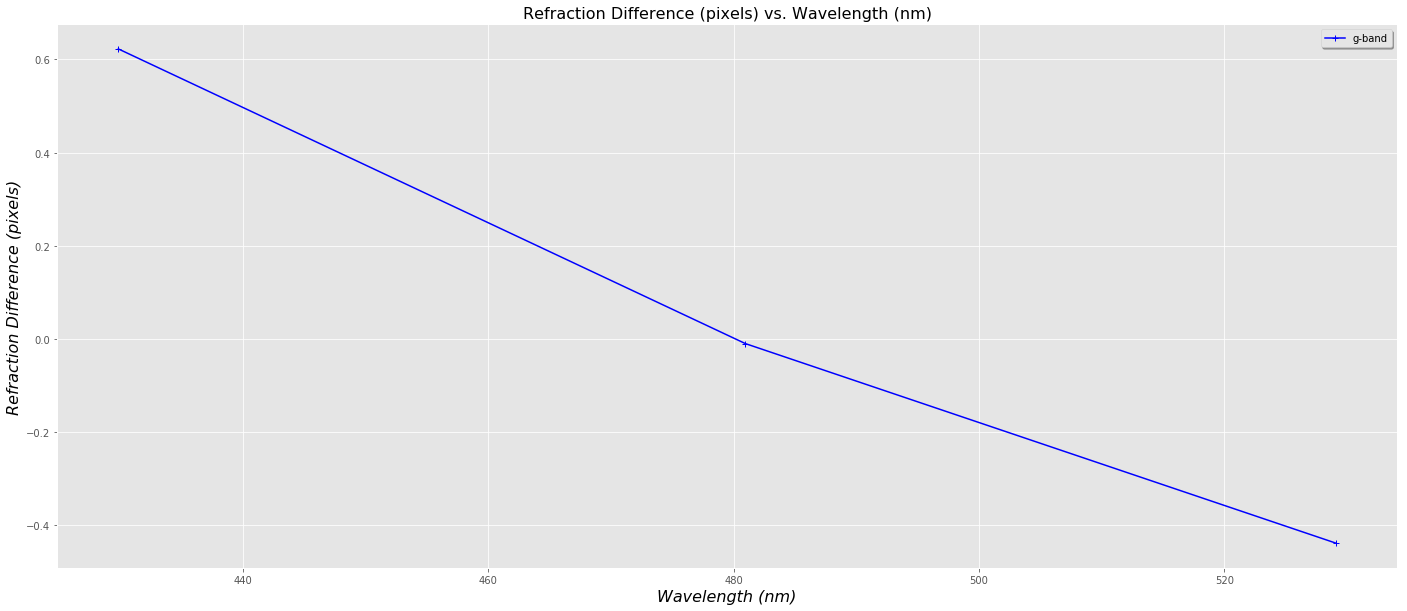

In [110]:
#G-Band
plot_subbands(gband_wavelength, gband_throughput, 'g-band')

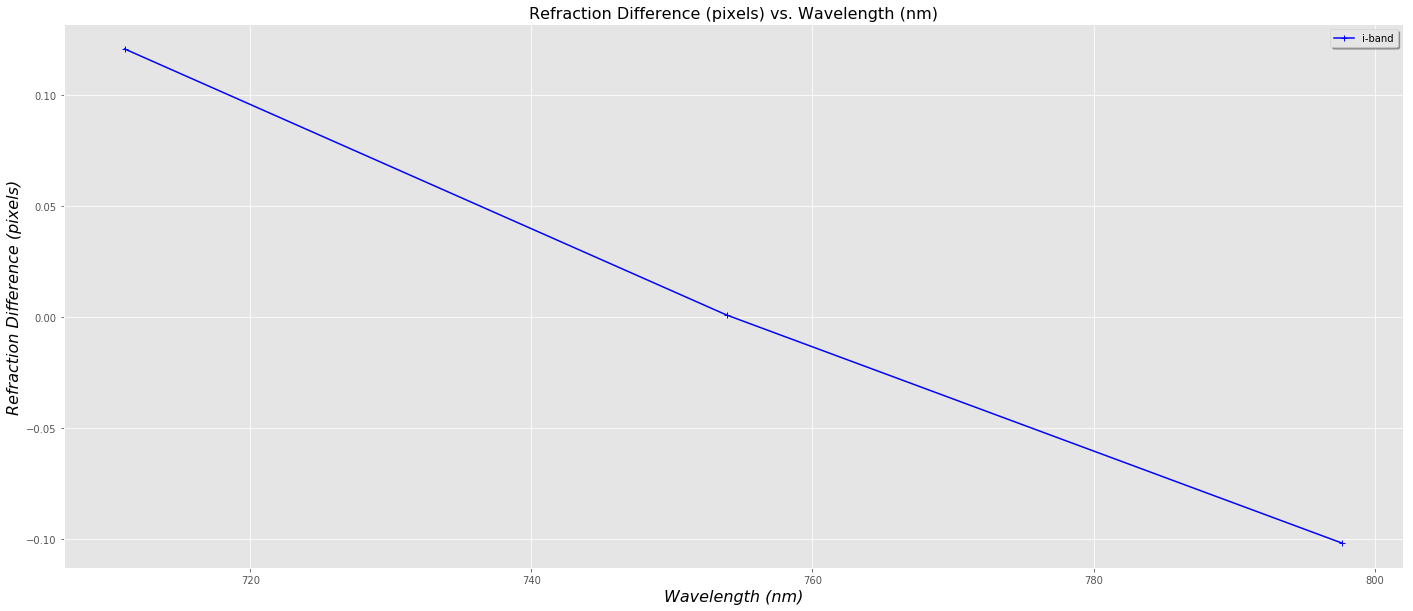

In [111]:
# I-Subband
plot_subbands(iband_wavelength, iband_throughput, 'i-band')

## Part 1c: Fitting Model

In [112]:
import lmfit
from lmfit.lineshapes import gaussian2d

def modelFunction():
    
    model = lmfit.models.gaussian2d()
    params = model.guess(z, x, y)
    result = model.fit(z, x=x, y=y, params=params) #weights=)
    lmfit.report_fit(result)
    result.plot()

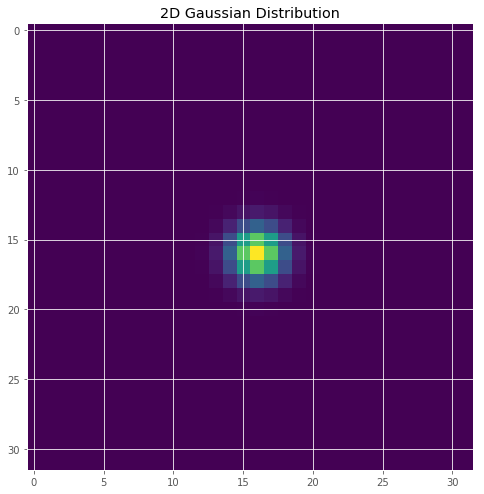

In [115]:
fwhm_conversion = 2 * np.sqrt(2 * np.log(2))

# Creating 2D Gaussian Functions
def gaussianFunction(x_dimension = 32, y_dimension = 32, xcenter = 16, ycenter = 16, sigmax = (0.8/0.26)/fwhm_conversion, sigmay = (0.8/0.26)/fwhm_conversion):
    x = np.linspace(0, x_dimension-1, x_dimension)
    y = np.linspace(0, y_dimension-1, y_dimension)
    x, y = np.meshgrid(x, y)
    
    diffx = x - xcenter
    diffy = y - ycenter
    gaussian = np.exp(-((diffx**2/(2*sigmax**2))+(diffy**2/(2*sigmay**2))))
    
    return gaussian

# Defining X, Y & Gaussian Values
gaussian_2d = gaussianFunction()

# Plot of Gaussian Distribution
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize = (8, 24))
ax.imshow(gaussian_2d)
ax.set_title('2D Gaussian Distribution');

In [116]:
# G-Band Image
g_wls, gimage, gdistribution = totalImage(gband_wavelength, gband_throughput, spectra_obs[4], relative_fluxdensity, gWeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin, 0.8, 16, 16)


TypeError: gaussian2d() got an unexpected keyword argument 'x_dimension'

In [117]:
# Gaussian Fit Function
def gaussianfit(z, subband):
    x, y = z.shape
    xmesh, ymesh = np.meshgrid(np.linspace(0, x-1, x), np.linspace(0, y-1, y))
    
    zflat = z.flatten()
    xflat = xmesh.flatten()
    yflat = ymesh.flatten()
    print(len(zflat), len(yflat), len(xflat))
    
    model = lmfit.models.Gaussian2dModel()
    params = model.guess(zflat, xflat, yflat)
    result = model.fit(zflat, x=xflat, y=yflat, params=params)
    lmfit.report_fit(result)
    
    fig, ax = plt.subplots(1, 1, figsize = (6, 6))
    fit = model.func(xmesh, ymesh, **result.best_values)
    gaussian_fittedimage = ax.imshow(fit)
    fig.colorbar(gaussian_fittedimage, orientation = 'vertical');
    ax.set_title("Gaussian Subband {} Distribution \n (Fit)".format(subband));

In [120]:
# 3-subband gaussian images

# Gaussian Subband 1
gaussian_g1_shift = offset_2dgaussian(0.8, 1, 0, difference(gband_wavelength, gband_throughput, 0))
g1_mean = np.mean(gaussian_g1_shift)
print("Gaussian Subband 1 Mean: {}".format(g1_mean))
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
g1shift = ax.imshow(gaussian_g1_shift);
fig.colorbar(g1shift, orientation = 'vertical')
ax.set_title('Gaussian Subband 1 Distribution')

# Gaussian Subband 2
gaussian_g2_shift = offset_2dgaussian(0.8, 1, 0, difference(gband_wavelength, gband_throughput, 1))
g2_mean = np.mean(gaussian_g2_shift)
print("Gaussian Subband 2 Mean: {}".format(g2_mean))
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
g2shift = ax.imshow(gaussian_g2_shift);
fig.colorbar(g2shift, orientation = 'vertical')
ax.set_title('Gaussian Subband 2 Distribution')

# Gaussian Subband 3
gaussian_g3_shift = offset_2dgaussian(0.8, 1, 0, difference(gband_wavelength, gband_throughput, 2))
g3_mean = np.mean(gaussian_g3_shift)
print("Gaussian Subband 3 Mean: {}".format(g3_mean))
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
g3shift = ax.imshow(gaussian_g3_shift);
fig.colorbar(g3shift, orientation = 'vertical');
ax.set_title('Gaussian Subband 3 Distribution');

TypeError: DCRshift() missing 6 required positional arguments: 'p_s', 'temperature', 'p_w', 'latitude', 'altitude', and 'zin'

In [119]:
# Differences

total_correctedmean = gdistribution * (g1_mean/totalmean) * 3

gdiff1 = total_correctedmean - gaussian_g2_shift - gaussian_g3_shift
gdiff2 = total_correctedmean - gaussian_g1_shift - gaussian_g3_shift
gdiff3 = total_correctedmean - gaussian_g1_shift - gaussian_g2_shift

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
totalimage_corrected = ax.imshow(total_correctedmean)
fig.colorbar(totalimage_corrected, orientation = 'vertical')
ax.set_title('Total Gaussian Distribution \n - Corrected Mean')

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
gaussian_subband1 = ax.imshow(gdiff1)
fig.colorbar(gaussian_subband1, orientation = 'vertical');
ax.set_title('Gaussian Subband 1 Distribution \n (Difference)');

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
gaussian_subband2 = ax.imshow(gdiff2)
fig.colorbar(gaussian_subband2, orientation = 'vertical');
ax.set_title('Gaussian Subband 2 Distribution \n (Difference)');

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
gaussian_subband3 = ax.imshow(gdiff3)
fig.colorbar(gaussian_subband3, orientation = 'vertical');
ax.set_title('Gaussian Subband 3 Distribution \n (Difference)');

NameError: name 'g1_mean' is not defined

In [118]:
# Gaussian Fit Subband 1

fit1 = gaussianfit(gdiff1, "1")
fit2 = gaussianfit(gdiff2, "2")
fit3 = gaussianfit(gdiff3, "3")

NameError: name 'gdiff1' is not defined